In [3]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.ensemble
import sksurv.linear_model

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import pandas as pd
import importlib
import numpy as np
import sklearn as skl
import scipy.stats as sp
import importlib

plt.ioff()
np.random.seed(99)

# Simulate Survival Function

In [5]:
# PH: 𝛼 = 2.0, 𝜆 = exp{3 + 0.1(x1 + x2 + x3 + x4 + x5 + x6) + x7}
#S(t|𝛼, 𝜆) = e ^−(t∕𝜆)𝛼
def sim_surv(N=100, 
            # T=100, 
            x_vars = 1, 
            lambda_f=None, 
            a=2, 
            alpha_f = None, 
            seed=999, 
            cens_ind = True,
            cens_scale = 20,
            err_ind = False):
    # np.random.seed(seed)

    x_mat = np.zeros((N, x_vars))
    for x in np.arange(x_vars):
        x1 = sp.bernoulli.rvs(.5, size = N)
        x_mat[:,x] = x1
    # calculate lambda
    
    # set lambda
    if lambda_f is None:
        lmbda = np.exp(2 + 0.3*(x_mat[:,0] + x_mat[:,1]) + x_mat[:,2])
    else:
        lmbda = eval(lambda_f)
    
    # set alpha if specified
    if alpha_f is None:
        a = np.repeat(a, N)
    else:
        a = eval(alpha_f)

    # add error
    if err_ind:
        error = sp.norm.rvs(0, .5, size = N)
        lmbda=lmbda + error

    # get time series
    # t = np.linspace(0,T, T)

    # calculate survival and event times
    # sv_mat = np.zeros((N, t.shape[0]))
    # tlat = np.zeros(N)
    # for idx, l in enumerate(lmbda):
    #     sv = np.exp(-1 * np.power((t/l), a[idx]))
    #     sv_mat[idx,:] = sv
        
    #     # generate event times 
    #     unif = np.random.uniform(size=1)
    #     ev = lmbda[idx] * np.power((-1 * np.log(unif)), 1/a[idx])
    #     tlat[idx] = ev
    
    # get the event times
    tlat = np.zeros(N)
    for idx, l in enumerate(lmbda):
        # generate event times 
        unif = np.random.uniform(size=1)
        ev = lmbda[idx] * np.power((-1 * np.log(unif)), 1/a[idx])
        tlat[idx] = ev
    


    if cens_ind:
        # censor
        cens = np.ceil(np.random.exponential(size = N, scale = cens_scale))

        # min cen and surv event
        t_event  = np.minimum(cens, np.ceil(tlat))
        status = (tlat <= cens) * 1
    else:
        cens=np.zeros(N)
        t_event = np.ceil(tlat)
        status = np.ones(N)
    
    # new 
    # get max event time
    T = int(t_event.max())
    print(f"max time is {T}")

    # get time series
    t = np.linspace(0,T, T)

    # get surv curve true
    sv_mat = np.zeros((N, t.shape[0]))
    for idx, l in enumerate(lmbda):
        sv = np.exp(-1 * np.power((t/l), a[idx]))
        sv_mat[idx,:] = sv
        

        

    return sv_mat, x_mat, lmbda, a, tlat, cens, t_event, status, T

# np.power()

# Get metrics and prep data

In [12]:
def get_x_info(x_mat):
    x = np.unique(x_mat, axis=0, return_index=True, return_counts=True)
    x_out, x_idx, x_cnt = x[0], x[1], x[2]
    return x_out, x_idx, x_cnt

def get_status_perc(status):
    out = status.sum()/status.shape[0]
    cens = 1-out
    return out, cens

def get_event_time_metric(t_event):
    t_mean = t_event.mean()
    t_max = t_event.max()
    return t_mean, t_max

def get_train_matrix(x_mat, t_event, status):
    et = pd.DataFrame({"status": status, "time":t_event})
    train = pd.concat([et, pd.DataFrame(x_mat)],axis=1)
    return train

def get_y_sklearn(status, t_event):
    y = np.array(list(zip(np.array(status, dtype="bool"), t_event)), dtype=[("Status","?"),("Survival_in_days", "<f8")])
    return y

# Survival plot

In [9]:
def plot_sv(x_mat, sv_mat, t, title="TITLE", save=False, dir=".", show=False):
    dist_x, dist_idx = np.unique(x_mat, axis=0, return_index=True)
    if type(t) == int:
        print("here")
        tt = np.arange(t)
    else:
        tt = t

    # print(tt)
    try:
        fig = plt.figure()
        if len(sv_mat) != len(dist_idx):
            for idx, i in enumerate(sv_mat[dist_idx]):
                plt.plot(tt, i, label = str(dist_x[idx]))
                plt.legend()
                plt.title(title)
        else:
            for idx, i in enumerate(sv_mat):
                # plt.step(i.x, i.y, label = str(dist_x[idx]))
                plt.plot(tt, i, label = str(dist_x[idx]))
                plt.legend()
                plt.title(title)
        if show:
            plt.show()
        if save:
            plt.savefig(f"{dir}/{title}.png")
    finally:
        plt.close(fig)

# Apply

In [6]:
# T = 50
sv_mat, x_mat, lmbda, a, tlat, cens, t_event, status, T = sim_surv(
                    N=1000, 
                    # T=T,
                    x_vars=2,
                    a = 2,
                    alpha_f= "1 + 2*x_mat[:,0]",
                    lambda_f = "np.exp(2.3 + 0.5*(0.8 * x_mat[:,0] + 1.3 * x_mat[:,1]))",
                    cens_ind=False,
                    cens_scale=40,
                    err_ind = False)

max time is 107


In [7]:
T

107

In [28]:
# check the outputs

# print(lmbda)
# print(a)
# print(sv_mat)
# print(tlat)
# print(x_mat)
# print(cens)
# print(t_event)
# print(status)

In [13]:
# apply
x_out, x_idx, x_cnt = get_x_info(x_mat)
t_mean, t_max = get_event_time_metric(t_event)
train = get_train_matrix(x_mat, t_event, status)
y = get_y_sklearn(status, t_event)
perc = get_status_perc(status)

In [324]:
# print(x_out)
# print(x_idx)
# print(x_cnt)
# y
perc

(1.0, 0.0)

here


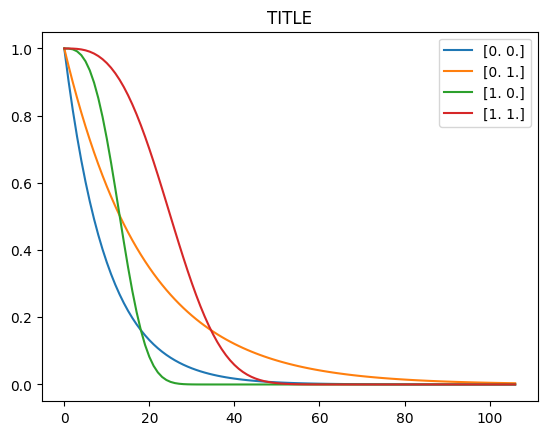

In [14]:
# plot survival true
# - x_mat provides the x info 
# - sv_mat[x_idx] is the index for the unique sv of the differnt var combinations
# - T is just the set time
plot_sv(x_mat, sv_mat[x_idx], t=T, show=True)


# CPH

In [15]:
cph = sks.linear_model.CoxPHSurvivalAnalysis()
cph.fit(pd.DataFrame(x_mat), y)
cph_surv = cph.predict_survival_function(pd.DataFrame(x_out))

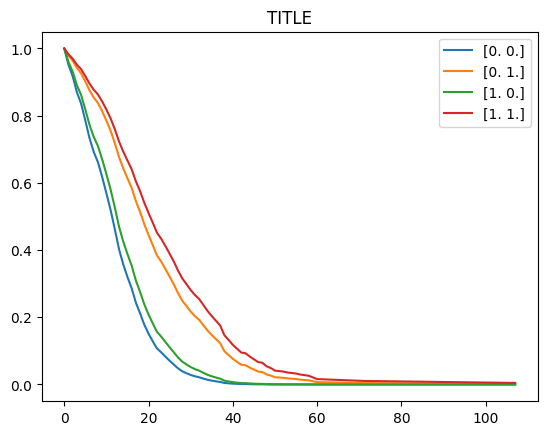

In [16]:
# get time and probs
cph_sv_t = cph_surv[0].x
cph_sv_val = [sf(cph_sv_t) for sf in cph_surv]

# add a time 0 with prob 1 
cph_sv_t = np.concatenate([np.array([0]), cph_sv_t])
cph_sv_val = [np.concatenate([np.array([1]), sv]) for sv in cph_sv_val]


plot_sv(x_mat, cph_sv_val, t=cph_sv_t, show=True)

# RSF

In [17]:
rsf = sksurv.ensemble.RandomSurvivalForest(
    n_estimators=1000, min_samples_split=100, min_samples_leaf=50, n_jobs=-1, random_state=20
)
rsf.fit(pd.DataFrame(x_mat), y)
rsf_surv = rsf.predict_survival_function(pd.DataFrame(x_out))

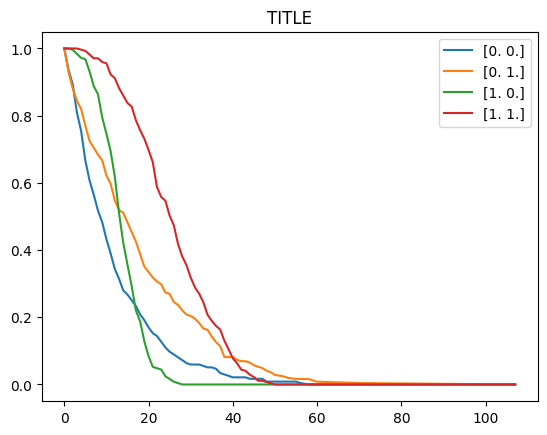

In [18]:
# adjust the prediction to include t0 w/ prob of 1
rsf_sv_t = rsf_surv[0].x
# rsf_sv_t = np.arange(rsf_surv[0].x.max())
# get prediction vals
rsf_sv_val = [sf(rsf_sv_t) for sf in rsf_surv]


# rsf_sv_val = []
# for sv in rsf_sv_val1:
    # sv[0]=1
    # rsf_sv_val.append(sv)

# add a time 0 with prob 1 
rsf_sv_t = np.concatenate([np.array([0]), rsf_sv_t])
rsf_sv_val = [np.concatenate([np.array([1]), sv]) for sv in rsf_sv_val]

# plot
plot_sv(x_mat, rsf_sv_val, t = rsf_sv_t, show=True)

# BART

In [51]:
def surv_pre_train2(data_x_n, data_y, X_TIME=True):
    # set up times
    # t_sort = np.append([0], np.unique(data_y["Survival_in_days"]))
    t_sort = np.unique(data_y["Survival_in_days"])
    t_ind = np.arange(0,t_sort.shape[0])
    t_dict = dict(zip(t_sort, t_ind))

    # set up delta
    delta = np.array(data_y["Status"], dtype = "int")
    
    t_out = []
    pat_x_out = []
    delta_out = []
    for idx, t in enumerate(data_y["Survival_in_days"]):
        # get the pat_time and use to get the array of times for the patient
        p_t_ind = t_dict[t]
        p_t_set = t_sort[0:p_t_ind+1]
        t_out.append(p_t_set)
        
        size = p_t_set.shape[0]
        # get patient array
        pat_x = np.tile(data_x_n.iloc[idx].to_numpy(), (size, 1))
        pat_x_out.append(pat_x)

        # get delta
        pat_delta = delta[idx]
        delta_set = np.zeros(shape=size, dtype=int)
        delta_set[-1] = pat_delta
        delta_out.append(delta_set)
    
    
    t_out, delta_out, pat_x_out = np.concatenate(t_out), np.concatenate(delta_out), np.concatenate(pat_x_out)
    if X_TIME:
        pat_x_out = np.array([np.concatenate([np.array([t_out[idx]]), i]) for idx, i in enumerate(pat_x_out)])
    return t_out, delta_out, pat_x_out

def get_bart_test(x_out, T):
    s0 = x_out.shape[0]
    s1 = x_out.shape[1]
    # create time range
    # d1 = np.arange(T+1)
    d1 = T
    # repeating time range
    d2 = np.tile(d1,s0).reshape(d1.shape[0]*s0,1)
    # repeat x_out and shape as long by nvar
    d3 = np.tile(x_out, d1.shape[0]).reshape(s0*d1.shape[0], s1)
    # holding matrix
    d4 = np.matrix(np.zeros((d3.shape[0], d3.shape[1] + 1))) # always +1 because only adding on time col
    # replace
    d4[:,0] = d2
    d4[:,1:(s1+1)] = d3
    return d4

# Did not make a difference to predict at all times
def get_bart_test2(x_out, T):
    s0 = x_out.shape[0]
    s1 = x_out.shape[1]
    # create time range
    # d1 = np.arange(T+1)
    # d1 = T
    d1 = np.arange(1,T+1)
    # repeating time range
    d2 = np.tile(d1,s0).reshape(d1.shape[0]*s0,1)
    # repeat x_out and shape as long by nvar
    d3 = np.tile(x_out, d1.shape[0]).reshape(s0*d1.shape[0], s1)
    # holding matrix
    d4 = np.matrix(np.zeros((d3.shape[0], d3.shape[1] + 1))) # always +1 because only adding on time col
    # replace
    d4[:,0] = d2
    d4[:,1:(s1+1)] = d3
    return d4

In [52]:
# prep train data
train_t, train_delta, train_x = surv_pre_train2(pd.DataFrame(x_mat), y)
# offset required
off = sp.norm.ppf(np.mean(train_delta))
# prep test data
test_x = get_bart_test(x_out, np.unique(train_t))
test_x2 = get_bart_test2(x_out, T)

In [21]:
with pm.Model() as bart:
    x_data = pm.MutableData("x", train_x)
    # off = pm.MutableData("off", off2)
    
    # f = pmb.BART("f", X = x_data, Y = train_d2, m=100)
    # f = pmb.BART("f", X = x_data, Y = train_delta, m=50, split_rules=[pmb.ContinuousSplitRule(), pmb.OneHotSplitRule(), pmb.OneHotSplitRule()])
    f = pmb.BART("f", X = x_data, Y = train_delta, m=100)
    z = pm.Deterministic("z", f + off)

    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    pm.Bernoulli("y_pred", p=(mu), observed=train_delta, shape=x_data.shape[0])
    bdata = pm.sample(random_seed=2, draws=200, tune = 200, cores=4)
     

Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 211 seconds.
/home/twj8/.local/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [65]:
with bart:
    # pm.set_data({"x":pd.DataFrame(test_x), "off":off_test})
    # pm.set_data({"x":pd.DataFrame(test_x2)})
    pm.set_data({"x":pd.DataFrame(test_x)})
    pp = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

Sampling: [f, y_pred]


In [55]:
pp

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [32]:
# get sv function
def get_sv_fx(pp, x_out):
    p0 = pp.posterior_predictive["mu"].values.shape[0]
    p1 = pp.posterior_predictive["mu"].values.shape[1]
    p2 = pp.posterior_predictive["mu"].values.shape[2]
    r0 = x_out.shape[0]
    r1 = int(p2/r0)
    pp_post = pp.posterior_predictive["mu"].values.reshape(p0*p1, p2).mean(axis=0).reshape(r0, r1)
    sv = (1-pp_post).cumprod(axis=1)
    return sv

In [66]:
bart_sv_fx = get_sv_fx(pp, x_out)

In [67]:
bart_sv_fx

array([[9.38942161e-01, 8.81905923e-01, 8.24912090e-01, 7.69859402e-01,
        7.11862167e-01, 6.57075016e-01, 6.06715982e-01, 5.60452038e-01,
        5.14079303e-01, 4.68612201e-01, 4.23435610e-01, 3.79220483e-01,
        3.37911647e-01, 3.00950746e-01, 2.67973160e-01, 2.37862383e-01,
        2.09748841e-01, 1.84794696e-01, 1.62253696e-01, 1.42805069e-01,
        1.25653535e-01, 1.10712345e-01, 9.75604509e-02, 8.59308182e-02,
        7.55823912e-02, 6.63363730e-02, 5.80810921e-02, 5.08299830e-02,
        4.44598475e-02, 3.88843450e-02, 3.39020409e-02, 2.94665809e-02,
        2.55058252e-02, 2.19780558e-02, 1.88047834e-02, 1.59699472e-02,
        1.35044254e-02, 1.13736019e-02, 9.55073159e-03, 8.01410032e-03,
        6.71683666e-03, 5.62559541e-03, 4.70862830e-03, 3.93539154e-03,
        3.28349641e-03, 2.73609145e-03, 2.27770658e-03, 1.89581103e-03,
        1.57676947e-03, 1.31137225e-03, 1.09040920e-03, 9.06952549e-04,
        7.54046708e-04, 6.26850940e-04, 5.21173146e-04, 4.334161

In [69]:
# bart_svt
bart_sv_t = np.unique(train_t)
# bart_sv_t = np.arange(1,T+1)

# add a time 0 with prob 1 
bart_sv_t = np.concatenate([np.array([0]), bart_sv_t])
bart_sv_val = [np.concatenate([np.array([1]), sv]) for sv in bart_sv_fx]

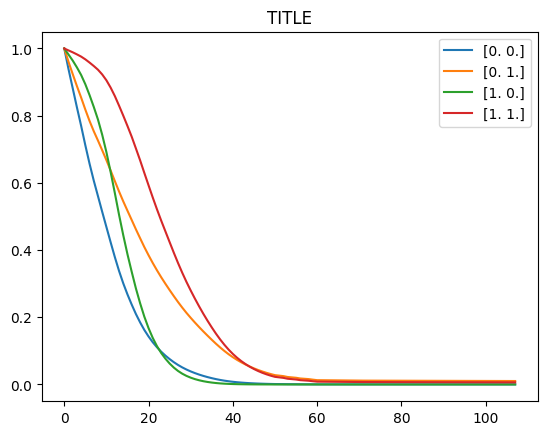

In [70]:
plot_sv(x_mat, bart_sv_val, t = bart_sv_t, show=True)

# Metrics

In [60]:
def get_metrics(f_t, f, T, quants = np.array([0.1, 0.25, 0.5, 0.75, 0.9])):
    # t_quant = np.array(np.ceil(np.quantile(np.arange(T), quants)), dtype="int")
    # t_quant = np.array(np.ceil(np.quantile(T, quants)), dtype="int")
    q1 = int(np.ceil(T.shape[0]/4))
    q2 = q1 * 2
    q3 = q1 * 3
    t_quant = [2,q1,q2,q3,-2]
    
    
    t_out = T[t_quant]
    # print(t_out)
    # f_t = np.matrix(rsf_fx)[:,t_quant]
    f_t = np.matrix(f_t)[:,t_quant]
    f = np.matrix(f)[:, t_quant]
    # f = np.matrix(sv_mat[dist_idx])[:, t_quant]

    rmse = np.round(np.sqrt(np.mean(np.power(f_t - f, 2), axis=0)), 4)
    bias = np.round(np.mean(f_t - f, axis = 0), 4)
    
    return rmse, bias, t_out

In [71]:
rsf_rmse, rsf_bias, t_quant = get_metrics( f_t = rsf_sv_val, f = sv_mat[x_idx], T = rsf_sv_t[rsf_sv_t <T])

cph_rmse, cph_bias, t_quant = get_metrics( f_t = cph_sv_val, f = sv_mat[x_idx], T = cph_sv_t[cph_sv_t < T])

bart_rmse, bart_bias, t_quant = get_metrics(f_t = bart_sv_val, f = sv_mat[x_idx], T = bart_sv_t[bart_sv_t < T])
print("rsf", rsf_rmse)
print("rsf", rsf_bias)
print("cph", cph_rmse)
print("cph", cph_bias)
print("bart", bart_rmse)
print("bart", bart_bias)

rsf [[0.0396 0.0308 0.0103 0.0183 0.0001]]
rsf [[ 0.0144  0.0156  0.0068 -0.0062  0.    ]]
cph [[0.0698 0.1372 0.03   0.038  0.0053]]
cph [[0.0167 0.0266 0.0059 0.0004 0.0027]]
bart [[0.0389 0.064  0.0158 0.0268 0.0053]]
bart [[ 0.0112  0.0151 -0.0043 -0.0058  0.0038]]


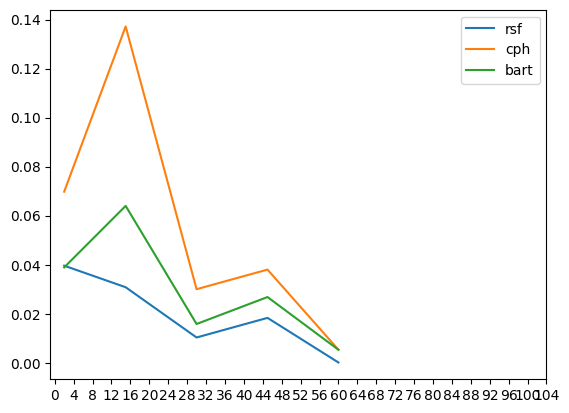

In [72]:
fig = plt.figure()
plt.plot(t_quant, rsf_rmse[0], label="rsf")
plt.plot(t_quant, cph_rmse[0], label = "cph")
plt.plot(t_quant, bart_rmse[0], label = "bart")
plt.xticks(np.arange(0,T,4))
plt.legend()
plt.show()
plt.close(fig)

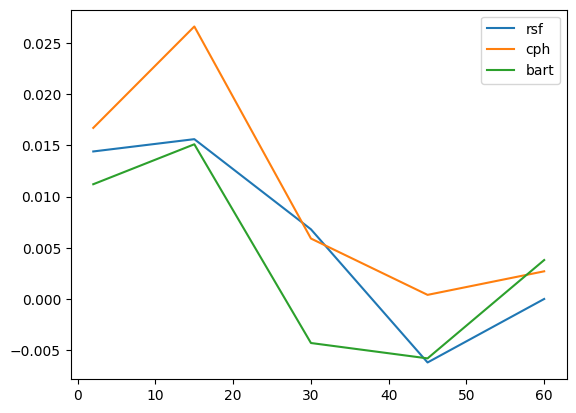

In [73]:
fig = plt.figure()
plt.plot(t_quant, rsf_bias[0], label="rsf")
plt.plot(t_quant, cph_bias[0], label = "cph")
plt.plot(t_quant, bart_bias[0], label = "bart")
plt.legend()
plt.show()
plt.close(fig)

In [370]:
train_x
train_delta
test_x
x_mat
y["Survival_in_days"].max()

106.0